<a href="https://colab.research.google.com/github/FrancescaMoi/SentimentAnalysis/blob/main/sentyment_analysis_IMDb_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sentiment analysis**
La **sentiment analysis** è una tecnica di *Natural Language Processing* che consiste nell'identificare l'intenzione/sentimento che sta dietro un testo. 

Questo tipo di analisi viene spesso eseguita sui feedback dei clienti per aiutare le aziende a monitorare il grado di apprezzamento del proprio prodotto e comprendere le esigenze dei clienti.

**Dataset**

Il dataset utilizzato consiste in un CSV contenente un elenco di 50K recensioni di film messe a disposizione dalla piattaforma [*kaggle*](https://www.kaggle.com/), estratte dal sito di [*IMDb*](https://www.imdb.com/), precedentemente etichettate come positive o negative. Il CSV può essere scaricato al seguente link:
[*IMDb dataset*](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews).

Una volta scaricato il CSV, carichiamo in memoria il dataset sfruttando le funzionalità della libreria [pandas](https://pandas.pydata.org/docs/index.html):

In [1]:
import pandas as pd

df = pd.read_csv("drive/MyDrive/Colab Notebooks/PilloleIA/data/IMDB Dataset.csv")
print('Shape of the dataset: ', df.shape)
df.head()


Shape of the dataset:  (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


**Dataset analysis**

Una delle fasi più importanti nello sviluppo di un sistema di IA è l'**analisi del dataset**. E' indispensabile essere a conoscenza di come si presenta il dato che si ha disposizione e di come sono distribuite le classi all'interno del dataset.

In [2]:
# Composizione del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [3]:
# Rimozione dei duplicati

# print('NaN counts of columns: \n ', df.isna().sum()) # check for duplicates
# df = df.dropna()

df = df.drop_duplicates()
print('\nShape of the unique dataset: ', df.shape)


Shape of the unique dataset:  (49582, 2)


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


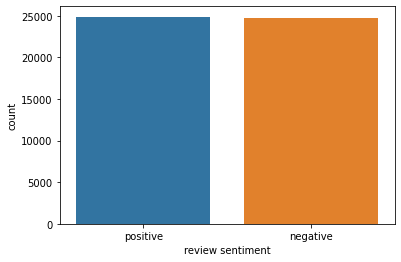

In [4]:
# Analisi distribuzione delle classi utilizzando un plot
import seaborn as sns
import matplotlib.pyplot as plt

labels = list(df.sentiment.unique())
ax = sns.countplot(df['sentiment'])
plt.xlabel('review sentiment')
ax.set_xticklabels(labels);

**Data Preprocessing**

In [5]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = nltk.WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [6]:
import re

def clean_text(text):
  text = re.sub("<br />", "", text) # removing break line tag
  text = re.sub("[^a-zA-Z0-9\s]", " ", text) # removing punctuation
  text = re.sub("\s+", " ", text) # removing multiple spaces
  text = text.strip() # removing spaces before and after the string
  text = text.lower() # transform the text in lower case format
  text_tokens = [word for word in text.split() if word not in stop_words] # removing stopwords
  text_tokens = [word for word in text_tokens if word.isalpha()] 
  # text_tokens = [lemmatizer.lemmatize(word) for word in text_tokens] # lemmatizing words
  cleaned_text = ' '.join(text_tokens)
  return cleaned_text

df['review'] = df['review'].apply(lambda x: clean_text(x))
df['review']

0        one reviewers mentioned watching oz episode ho...
1        wonderful little production filming technique ...
2        thought wonderful way spend time hot summer we...
3        basically family little boy jake thinks zombie...
4        petter mattei love time money visually stunnin...
                               ...                        
49995    thought movie right good job creative original...
49996    bad plot bad dialogue bad acting idiotic direc...
49997    catholic taught parochial elementary schools n...
49998    going disagree previous comment side maltin on...
49999    one expects star trek movies high art fans exp...
Name: review, Length: 49582, dtype: object

**Split the dataset**

In [7]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['sentiment'])

print("Train set shape: ", df_train.shape)
print("Test set shape: ", df_test.shape)

print("\nTrain set classes distribution:\n", df_train['sentiment'].value_counts())
print("\nTest set classes distribution:\n", df_test['sentiment'].value_counts())



Train set shape:  (39665, 2)
Test set shape:  (9917, 2)

Train set classes distribution:
 positive    19907
negative    19758
Name: sentiment, dtype: int64

Test set classes distribution:
 positive    4977
negative    4940
Name: sentiment, dtype: int64


**Vectorize texts**

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
train_vectors = vectorizer.fit_transform(df_train['review'])
test_vectors = vectorizer.transform(df_test['review'])


In [12]:
vectorized_train_df = pd.DataFrame(train_vectors.toarray(), columns=vectorizer.get_feature_names())
vectorized_train_df.head()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,able,absolutely,across,act,acted,acting,action,actor,actors,actress,...,wrote,yeah,year,years,yes,yet,york,young,younger,zombie
0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.171066,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.000000,0.000000,0.0,0.162827,0.0,0.199891,0.133465,0.0,0.115054,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.065919,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.048219,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.000000,0.127153,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.162306,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.037630,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.125327,0.0,0.0


**Training**

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(train_vectors, df_train['sentiment'])

RandomForestClassifier()

**Testing and results evaluation**

In [11]:
from sklearn.metrics import accuracy_score,precision_score,recall_score, f1_score

y_pred = rf_model.predict(test_vectors)
y_test = df_test['sentiment']

accuracy = round(accuracy_score(y_test, y_pred), 3)
precision = round(precision_score(y_test, y_pred, pos_label='positive'), 3)
recall = round(recall_score(y_test, y_pred, pos_label='positive'), 3)
f1 = round(f1_score(y_test,y_pred, pos_label='positive'), 3)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1_score: ", f1)

Accuracy:  0.827
Precision:  0.826
Recall:  0.832
F1_score:  0.829
